Markov Chain Monte Carlo (MCMC) methods can be used to estimate the parameters of linear regression models. In this post, the distributional forms and algorithms associated with two Gibbs sampling approaches are outlined: the full conditionals approach and the composition method.

The dataset used in what follows is available [here](https://gist.github.com/jtrive84/96757393423b2599c7d5da361fdf024b/raw/82000835b7c3b70dcf21a9ab43c59db700b78136/Refrigerator.csv)
and represents refrigerator price as a function of a number of features. The objective is to estimate PRICE as a function of ECOST, FSIZE, SHELVES and FEATURES, where:

- **PRICE**: Response, cost of refrigerator.    
- **FSIZE**: Size of freezer compartment.   
- **ECOST**: Annual energy cost to operate refrigerator.  
- **SHELVES**: Number of shelves. 
- **FEATURES**: Number of features. 




### I. The Full Conditionals Method

First determine the joint kernel, which is the product of the likelihood and all prior distributions. The joint kernel will be proportional to the posterior distribution:

$$
\begin{align}
f(\beta, \sigma^{2}|X, y) &\propto f(y|X, \beta, \sigma^{2}) \times f(\beta) \times f(\sigma^{2}).
\end{align}
$$

<br>

The likelihood, $f(y|X, \beta, \sigma^{2})$, is given by:


$$
\begin{align}
y|X, \beta, \sigma^{2} &\sim \mathcal{N}(X\beta, \sigma^{2}I)\\
 &= \prod_{i=1}^{n} f(y_{i}|x_{i}, \beta, \sigma^{2}) \\
&= (2\pi\sigma^{2})^{-n/2} \mathrm{exp}\Big\{\frac{1}{2\sigma^{2}}\sum_{i=1}^{n} (y_{i} - \beta^{T}x_{i})^{2}\Big\}\\
&= (2\pi\sigma^{2})^{-n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}
\end{align}
$$
<br>


For the parameter vector $\beta$ we assume an improper uniform prior over the real line. For the variance, we assume a uniform prior over the real line for $\mathrm{log}(\sigma^{2})$. If we transform the uniform prior on $\mathrm{log}(\sigma^{2})$ into a density for $\sigma^{2}$, we obtain $f(\sigma^{2}) \propto 1/\sigma^{2}$. This is a common reference prior for the variance used within the context of Bayesian linear regression.       

Since the prior distribution for the parameter vector $f(\beta)$ can be treated as a multiplicative constant which can be ignored, the expression for the posterior reduces to:

$$
\begin{align}
f(\beta, \sigma^{2}|X, y) &\propto \frac{1}{\sigma^{2}} \times (2\pi\sigma^{2})^{-n/2}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}\\
&\propto (\sigma^{2})^{-(n/2 + 1)}\mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}.\\
\end{align}
$$

Note that posterior distribution is asymptotically equivalent to the expression for the model likelihood. 

Gibbs sampling requires identifying the full conditional distribution for each parameter, holding all other parameters constant. 
To find the full conditional distribution for $\beta$, select only the terms from the joint kernel that include $\beta$. Doing so results in:

$$
f(\beta|X, y, \sigma^{2}) \propto \mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}(y-X\beta)^{T}(y-X\beta)\Big\}
$$
<br>  

After distributing the transpose, removing multiplicative constants and performing a bit of reorganization, we arrive at:

$$
f(\beta|X, y, \sigma^{2}) \propto \mathrm{exp}\Big\{-\frac{1}{2\sigma^{2}}[\beta^{T}X^{T}X\beta - 2\beta^{T}X^{T}y]\Big\}.\\
$$


Upon completing the square, we find the distribution for $\beta$ to be normal with mean $(X^{T}X)^{-1}X^{T}y\hspace{.25em}$ and variance $\hspace{.25em}\sigma^{2}(X^{T}X)^{-1}$.

For $\sigma^{2}$, with $\beta$ assumed fixed, we obtain:

$$
f(\sigma^{2}|X, y, \beta) \propto (\sigma^{2})^{-(n/2 + 1)}\mathrm{exp}\Big\{-\frac{\mathrm{SSR}}{2\sigma^{2}}\Big\},
$$

where $\mathrm{SSR}$ represents the sum of squared residuals under the specified value of $\beta$. This is proportional to an inverse gamma distribution with $a = n/2$ and $b = \mathrm{SSR}/2$.


#### Full Conditionals Approach for Sampling from the Posterior Distribution:

1. Establish starting values for $\beta_{p}$ and $\sigma^{2}$. We use $\beta^{(0)} = \hat\beta_{ols}$ and $\hat \sigma_{0}^{2} = \mathrm{SSR} / (n - p)$  

2. Sample $\beta_{p}$ from multivariate normal distribution with $\sigma^{2}$ fixed.   

3. Sample $\sigma^{2}$ from inverse gamma distribution with $\beta_{p}$ fixed. 


In the code below, we run the sampler for 10,000 iterations, discarding the first 1,000 samples. 

In [1]:
"""
The full conditionals Gibbs sampling method. 

    PRICE ~ "ECOST" + "FSIZE" + "SHELVES" + "FEATURES"
"""
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from scipy import stats
from scipy.linalg import cholesky

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 10000)
np.set_printoptions(suppress=True)


data_url = "https://gist.github.com/jtrive84/96757393423b2599c7d5da361fdf024b/raw/82000835b7c3b70dcf21a9ab43c59db700b78136/Refrigerator.csv"

df = pd.read_csv(data_url)

variates = ["ECOST", "FSIZE", "SHELVES", "FEATURES"]
X = df[variates].values
y = df["PRICE"].values.reshape(-1, 1)
X = np.concatenate([np.ones(y.size).reshape(-1, 1), X], axis=1)

n, p = X.shape
M = 10000
burnin = 1000
prng = np.random.RandomState(516)

# Initialize arrays to hold posterior samples.
betas, sigma2 = np.zeros([M, p]), np.ones(M)

# Initialize parameter arrays and compute covariance matrix.
b_ols = np.linalg.inv(X.T @ X) @ X.T @ y
V = np.linalg.inv(X.T @ X)
sigma2[0] = ((y - X @ b_ols).T @ (y - X @ b_ols) / (n - p)).item()
betas[0, :] = b_ols.T

# Gibbs sampling from full conditionals. At each iteration, p independent 
# standard normal random variates are sampled, which are transformed into 
# a draw from a multivariate normal density with mean betas[i, :] and 
# covariance V. 
for ii in range(1, M):
    
    # Sample from full conditional distribution for betas.
    betas[ii,:] = b_ols.T + prng.randn(p).reshape(1, -1) @ cholesky(sigma2[ii - 1] * V)
    
    # Sample from full conditional distribution for variance. 
    sigma2[ii] = stats.invgamma.rvs(
        a=.50 * n, 
        scale=.50 * ((y - X @ betas[ii,:].reshape(-1, 1)).T @ (y - X @ betas[ii,:].reshape(-1, 1))).item(),
        random_state=prng
        )

# Remove burnin samples.
betas = betas[burnin:,:]
sigma2 = sigma2[burnin:]


Traceplots can be produced to visualize sampling variability across iterations:

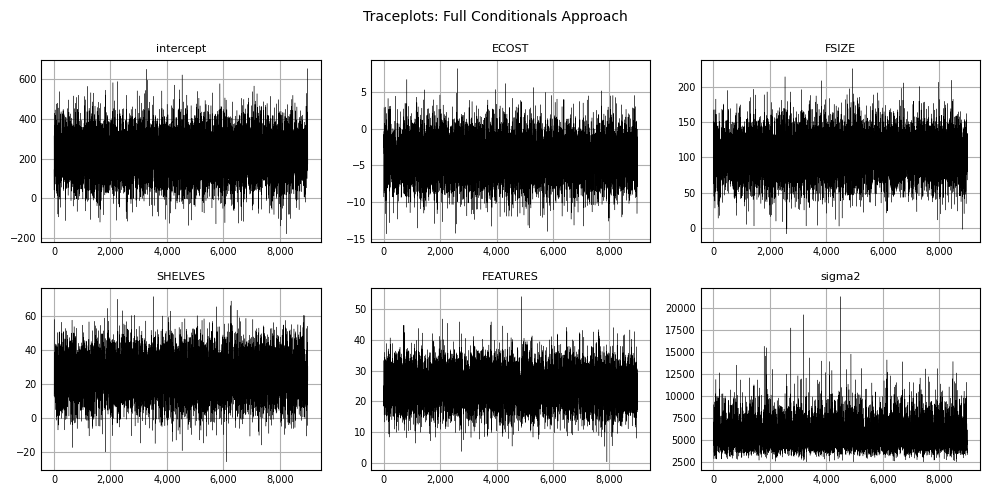

In [2]:
# | fig-cap: Traceplot for each feature in model using full conditionals approach
# | fig-alt: Traceplot for each feature in model using full conditionals approach

# Combine beta and sigma2 arrays to create traceplots. 
varnames = ["intercept"] + variates + ["sigma2"]
Xall1 = np.hstack([betas, sigma2.reshape(-1, 1)])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), tight_layout=True) 

indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for indx, (varname, (ii, jj)) in enumerate(zip(varnames, indices)):
    
    ax[ii, jj].set_title(varname, color="#000000", loc="center", fontsize=8)
    ax[ii, jj].plot(Xall1[:,indx], color="#000000", linewidth=.25, linestyle="-")
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].set_xlabel("")
    ax[ii, jj].set_ylabel("")
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=7)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=7)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 

plt.suptitle("Traceplots: Full Conditionals Approach", fontsize=10)
plt.show();


Histograms for each parameter can be generated from the posterior samples:

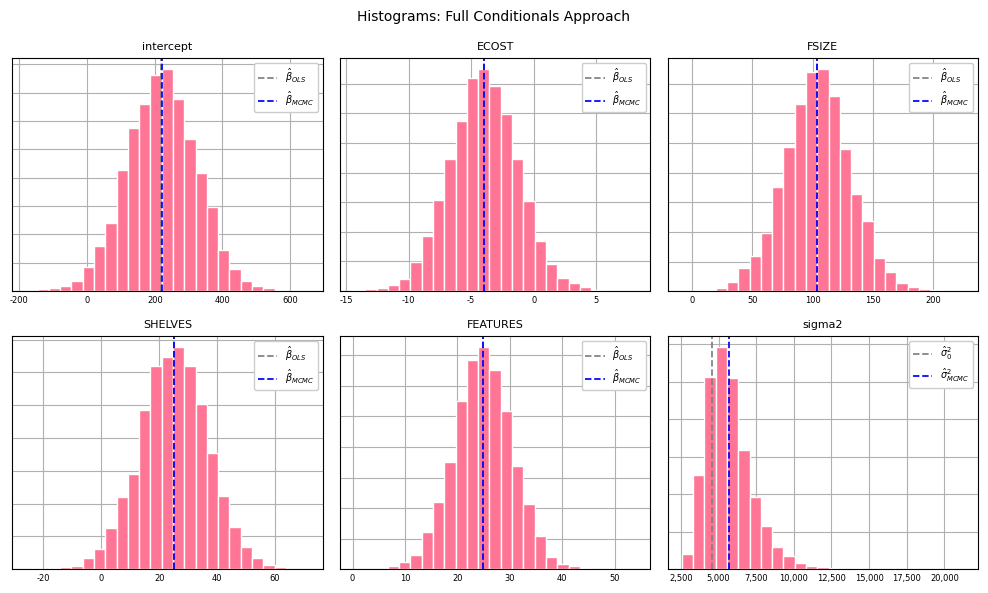

In [3]:
# | fig-cap: Histogram for each feature using full conditionals approach
# | fig-alt: Histogram for each feature using full conditionals approach


# Create histograms from posterior samples with overlaid ols estimates.
hist_color = "#ff7595"
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), tight_layout=True) 

plt_ols = np.append(b_ols.ravel(), sigma2[0])

indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for indx, (varname, (ii, jj)) in enumerate(zip(varnames, indices)):
    
    ax[ii, jj].set_title(varname, color="#000000", loc="center", fontsize=8)
    ax[ii, jj].hist(
        Xall1[:,indx], 25, density=True, alpha=1, color=hist_color, 
        edgecolor="#FFFFFF", linewidth=1.0
        )
    label0 = r"$\hat \sigma_{0}^{2}$" if indx == 5 else r"$\hat \beta_{OLS}$" 
    label1 = r"$\hat \sigma_{MCMC}^{2}$" if indx == 5 else r"$\hat \beta_{MCMC}$" 
    ax[ii,jj].axvline(plt_ols[indx], color="grey", linewidth=1.25, linestyle="--", label=label0)
    ax[ii,jj].axvline(Xall1[:,indx].mean(), color="blue", linewidth=1.25, linestyle="--", label=label1)
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii,jj].set_yticklabels([])
    ax[ii, jj].set_xlabel("")
    ax[ii, jj].set_ylabel("")
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 
    ax[ii,jj].legend(loc="upper right", fancybox=True, framealpha=1, fontsize="x-small")

plt.suptitle("Histograms: Full Conditionals Approach", fontsize=10)
plt.show();




### II. Composition Method

The composition method can also be used to generate posterior samples for $\beta$ and $\sigma^{2}$. Using this approach, the posterior distribution is decomposed
into 1) the conditional distribution for $\beta$ given $\sigma^{2}$ and 2) the marginal distribution for  $\sigma^{2}$:

$$
f(\beta, \sigma^{2}| X, y) \propto f(\beta|\sigma^{2}, X, y) \times f(\sigma^{2}|X, y)
$$

$f(\sigma^{2}|X, y)$ is an inverse gamma distribution with $\alpha = (n - p) / 2$ and $\beta = (n - p) \times \mathrm{SSR} / 2$, where $n$ is the number of observations in the dataset and $p$ the number of predictors in $X$. $\mathrm{SSR}$ represents the sum of squared residuals obtained from the OLS estimate.  

As before, the conditional distribution for $\beta$, $f(\beta|\sigma^{2}, X, y)$, is multivariate normal with mean $(X^{T}X)^{-1}X^{T}y$ and variance $\sigma^{2}(X^{T}X)^{-1}$.   

The composition method is faster than the full conditionals method since we can draw all samples from $f(\sigma^{2}|X, y)$ upfront. 

  
#### Composition Method Approach for Sampling from the Posterior Distribution:

1. Compute $\hat \beta$ via OLS and $V = (X^{T}X)^{-1}$.

2. Compute $SSR = \frac{1}{n - p}(y - X\hat \beta)^{T}(y - X\hat \beta)$.

3. Draw $m$ samples from $IG\big(\frac{n - p}{2}, \frac{(n - p) \times \mathrm{SSR}}{2}\big)$.

4. For $i = 1, \cdots, m$: Draw $\beta^{(i)}$ from $f(\beta|\sigma^{2(i)}, X, y)$: $\beta^{(i)} \sim \mathcal{N}(\hat \beta, \sigma^{2(i)}V)$.


In [4]:
"""
Drawing posterior samples using the composition method.

    PRICE ~ "ECOST" + "FSIZE" + "SHELVES" + "FEATURES"
"""

n, p = X.shape
M = 10000
burnin = 1000
prng = np.random.RandomState(516)

# Initialize betas to hold posterior samples.
betas = np.zeros([M, p])

# Compute OLS estimate, V and SSR. 
b_ols = np.linalg.inv(X.T @ X) @ X.T @ y
V = np.linalg.inv(X.T @ X)
SSR = (y - X @ b_ols).T @ (y - X @ b_ols) / (n - p)

# Draw M samples from marginal distribution for sigma2.
sigma2 = stats.invgamma.rvs(a=.50 * (n - p), scale=.50 * (n - p) * SSR, size=M, random_state=prng)

# Simulate sequence of beta draws for each value in sigma2.
for ii in range(M):
    betas[ii,:] = b_ols.T + prng.randn(p).reshape(1, -1) @ cholesky(sigma2[ii] * V)



As before, we produce traceplots for each variable and $sigma^2$:

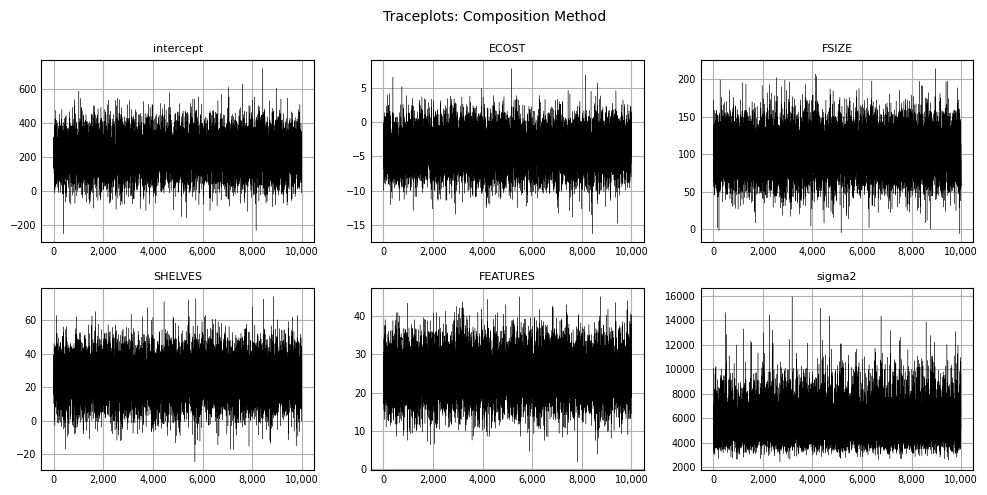

In [5]:
# | fig-cap: Traceplot for each feature in model using composition method
# | fig-alt: Traceplot for each feature in model using composition method

varnames = ["intercept"] + variates + ["sigma2"]
Xall2 = np.hstack([betas, sigma2.reshape(-1, 1)])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 5), tight_layout=True) 

indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for indx, (varname, (ii, jj)) in enumerate(zip(varnames, indices)):
    
    ax[ii, jj].set_title(varname, color="#000000", loc="center", fontsize=8)
    ax[ii, jj].plot(Xall2[:,indx], color="#000000", linewidth=.25, linestyle="-")
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii, jj].set_xlabel("")
    ax[ii, jj].set_ylabel("")
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=7)
    ax[ii, jj].tick_params(axis="x", which="minor", direction='in', labelsize=7)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=7)
    ax[ii, jj].tick_params(axis="y", which="minor", direction='in', labelsize=7)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 

plt.suptitle("Traceplots: Composition Method", fontsize=10)
plt.show();


As well as histograms:

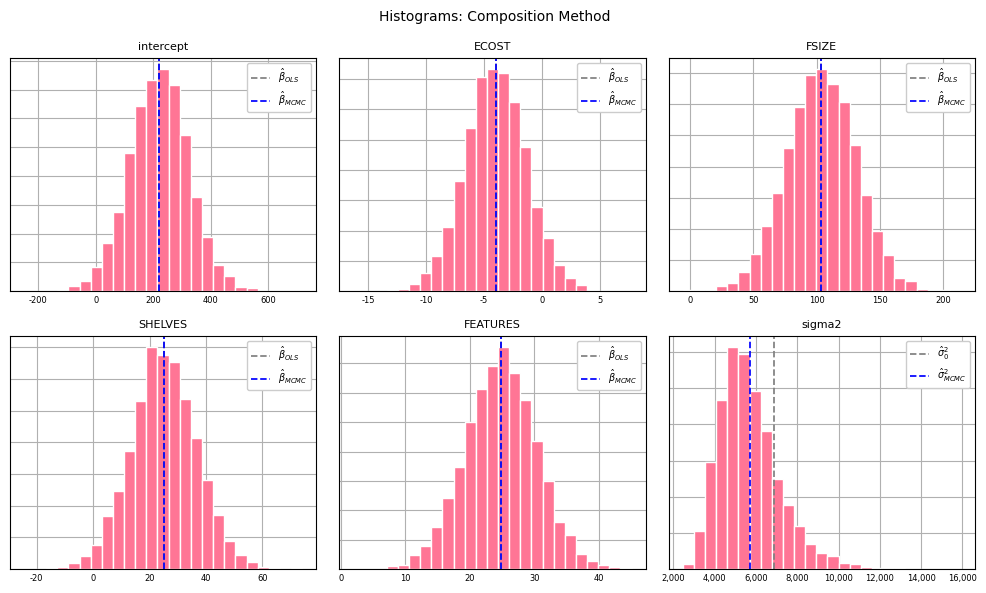

In [6]:
# | fig-cap: Histogram for each feature using composition method
# | fig-alt: Histogram for each feature using composition method
hist_color = "#ff7595"
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), tight_layout=True) 

plt_ols = np.append(b_ols.ravel(), sigma2[0])

indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for indx, (varname, (ii, jj)) in enumerate(zip(varnames, indices)):
    
    ax[ii, jj].set_title(varname, color="#000000", loc="center", fontsize=8)
    ax[ii, jj].hist(
        Xall2[:,indx], 25, density=True, alpha=1, color=hist_color, 
        edgecolor="#FFFFFF", linewidth=1.0
        )
    label0 = r"$\hat \sigma_{0}^{2}$" if indx == 5 else r"$\hat \beta_{OLS}$" 
    label1 = r"$\hat \sigma_{MCMC}^{2}$" if indx == 5 else r"$\hat \beta_{MCMC}$" 
    ax[ii,jj].axvline(plt_ols[indx], color="grey", linewidth=1.25, linestyle="--", label=label0)
    ax[ii,jj].axvline(Xall2[:,indx].mean(), color="blue", linewidth=1.25, linestyle="--", label=label1)
    ax[ii, jj].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
    ax[ii,jj].set_yticklabels([])
    ax[ii, jj].set_xlabel("")
    ax[ii, jj].set_ylabel("")
    ax[ii, jj].tick_params(axis="x", which="major", direction='in', labelsize=6)
    ax[ii, jj].tick_params(axis="y", which="major", direction='in', labelsize=6)
    ax[ii, jj].xaxis.set_ticks_position("none")
    ax[ii, jj].yaxis.set_ticks_position("none")
    ax[ii, jj].grid(True)   
    ax[ii, jj].set_axisbelow(True) 
    ax[ii,jj].legend(loc="upper right", fancybox=True, framealpha=1, fontsize="x-small")

plt.suptitle("Histograms: Composition Method", fontsize=10)
plt.show();



Posterior percentiles from the full conditionals approach and composition method can be compared:

In [7]:
"""
Comparing posterior percentiles for full conditionals and composition approaches.
"""

peval = [1, 5, 25, 50, 75, 95, 99]
pcols = [f"{ii:.0f}%" for ii in peval]

for indx, varname in enumerate(varnames):
    
    # Determine percentiles generated via full-conditionals.
    df1 = pd.DataFrame(
        np.round(np.percentile(Xall1[:, indx], q=peval), 2).reshape(1,-1), 
        columns=pcols,index=[f"{varname}: conditionals"]
        )
    
    # Determine percentiles generated via composition method.
    df2 = pd.DataFrame(
        np.round(np.percentile(Xall2[:, indx], q=peval), 2).reshape(1,-1), 
        columns=pcols, index=[f"{varname}: composition"]
        )
    df = pd.concat([df1, df2])
    display(df)


,1%,5%,25%,50%,75%,95%,99%
intercept: conditionals,-25.01,51.28,150.96,221.28,289.90,386.74,464.17
intercept: composition,-21.44,50.76,152.43,221.71,288.77,387.09,461.41


,1%,5%,25%,50%,75%,95%,99%
ECOST: conditionals,-10.34,-8.41,-5.77,-4.0,-2.20,0.39,2.62
ECOST: composition,-10.20,-8.34,-5.76,-4.0,-2.21,0.38,2.28


,1%,5%,25%,50%,75%,95%,99%
FSIZE: conditionals,38.83,58.12,85.95,103.97,121.74,148.78,169.22
FSIZE: composition,39.05,57.93,85.41,103.99,122.53,148.96,168.51


,1%,5%,25%,50%,75%,95%,99%
SHELVES: conditionals,-2.56,5.70,17.33,25.19,32.86,44.09,52.25
SHELVES: composition,-2.71,5.68,17.42,24.81,32.72,44.32,52.66


,1%,5%,25%,50%,75%,95%,99%
FEATURES: conditionals,11.87,15.60,21.25,24.87,28.68,34.11,38.15
FEATURES: composition,11.79,15.68,21.13,24.86,28.46,33.87,37.89


,1%,5%,25%,50%,75%,95%,99%
sigma2: conditionals,3209.36,3706.92,4620.93,5465.36,6527.58,8570.83,10609.79
sigma2: composition,3194.00,3691.71,4649.74,5467.54,6490.48,8482.73,10295.27



### Posterior Predictive Samples

For a new set of predictors $\tilde{X}$, we may be interested in quantifying the variability in the price estimate given our model.
This can be accomplished by sampling from the posterior predictive distribution, $f(\tilde{y}|y)$. If $\beta$ and $\sigma^{2}$
were known exactly, the distribution for $\tilde{y}$ would be completely specified as $\mathcal{N}(\tilde{X}\beta, \sigma^{2}I)$. But since
we have only estimates of $\beta$ and $\sigma^{2}$, we need to sample from the posterior predictive distribution $f(\tilde{y}|y)$ as follows:

1. For $i = 1, \cdots, n$: Draw $(\beta^{(i)}, \sigma^{2(i)})$ from posterior samples.
2. Draw $\tilde{y}^{(i)} \sim \mathcal{N}(\tilde{X}\beta^{(i)}, \sigma^{2{(i)}}I)$.

The code that follows generates 5000 posterior predictive samples for a new set of predictors.

In [8]:

# Generating posterior predictive samples for a new set of predictors.

n = 5000
Xnew = [1, 82, 5.1, 2, 8]

# Determine which 5000 parameter sets to use for sampling.
indices = prng.choice(range(Xall2.shape[0]), size=n, replace=False)
params = Xall2[indices,:]
samples = []

for ii in range(n):
    beta, v = params[ii, :-1], params[ii, -1]
    mu = np.dot(beta, Xnew)
    y_ii = prng.normal(loc=mu, scale=sqrt(v))
    samples.append(y_ii)

samples = np.asarray(samples)


Viewing the histogram of posterior predictive samples:

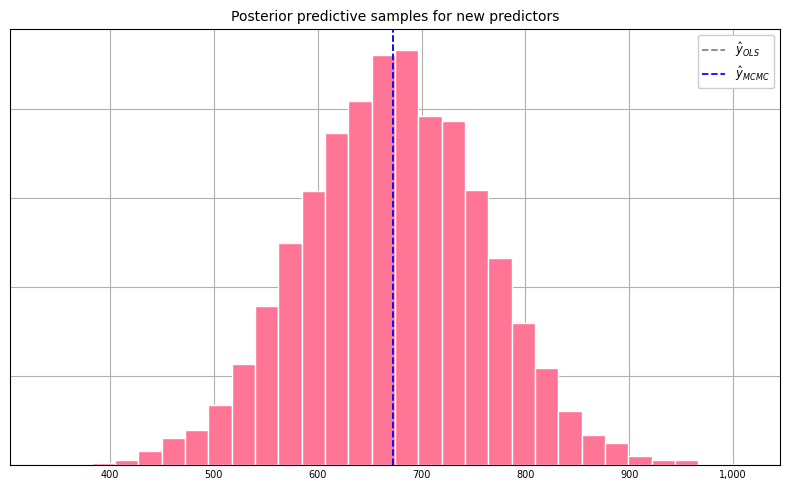

In [9]:
# | fig-cap: Histogram of posterior predictive samples
# | fig-alt: Histogram of posterior predictive samples

hist_color = "#ff7595"
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), tight_layout=True) 
ax.set_title(
    "Posterior predictive samples for new predictors", color="#000000", loc="center", fontsize=10
    )
ax.hist(
    samples, 30, density=True, alpha=1, color=hist_color, 
    edgecolor="#FFFFFF", linewidth=1.0
    )
label0, label1 = r"$\hat{y}_{OLS}$", r"$\hat y_{MCMC}$" 
ax.axvline(np.dot(b_ols.T, Xnew), color="grey", linewidth=1.25, linestyle="--", label=label0)
ax.axvline(samples.mean(), color="blue", linewidth=1.25, linestyle="--", label=label1)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_yticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis="x", which="major", direction='in', labelsize=7)
ax.tick_params(axis="y", which="major", direction='in', labelsize=7)
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")
ax.grid(True)   
ax.set_axisbelow(True) 
ax.legend(loc="upper right", fancybox=True, framealpha=1, fontsize="small")
plt.show();


Finally, percentiles of the posterior predictive samples:

In [10]:

peval = [1, 5, 25, 50, 75, 95, 99]
pcols = [f"{ii:.0f}%" for ii in peval]

df = pd.DataFrame(
    np.round(np.percentile(samples, q=peval), 2).reshape(1,-1), 
    columns=pcols,index=["posterior predictive samples"]
    )
df.head(1)

,1%,5%,25%,50%,75%,95%,99%
posterior predictive samples,464.64,530.08,613.37,673.32,731.45,813.15,883.41
